In [1]:
import rasterio
import cv2
import numpy as np
import geopandas as gpd
from tqdm import tqdm_notebook
import os

from shapely.ops import split as shapely_split
from shapely.geometry import Polygon, Point, MultiPoint, LineString
import shapely

In [2]:
def polygonize(contours, meta, transform=True):
    polygons = []
    for i in tqdm_notebook(range(len(contours))):
        c = contours[i]
        n_s = (c.shape[0], c.shape[2])
        if n_s[0] > 2:
            if transform:
                polys = [tuple(i) * meta['transform'] for i in c.reshape(n_s)]
            else:
                polys = [tuple(i) for i in c.reshape(n_s)]
            polygons.append(Polygon(polys))
    return polygons

In [22]:
raster_mask = "/mnt/storage_4tb/ymi/geo_data/40m_for_ori/citrusuco/v5_tta_full_504/rgb_504_rgg_bin.tif"
rows_path = "/mnt/storage_4tb/ymi/geo_data/40m_for_ori/citrusuco/row_data/504/row_data.geojson"
detected_polygon_path = "/mnt/storage_4tb/ymi/geo_data/40m_for_ori/citrusuco/row_data/504/detected_polygon.geojson"

In [25]:
with rasterio.open(raster_mask, "r") as src:
    raster_array = src.read(1)
    meta = src.meta
    raster_array = (raster_array > 0.95).astype(np.uint8)
    im2, contours, hierarchy = cv2.findContours(raster_array.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    polygons = polygonize(contours, meta, transform=True)

In [30]:
row_df = gpd.read_file(rows_path)

In [34]:
test_line = row_df['geometry'][0]

In [86]:
def save_gpd_df(save_path, geom_list, meta):
    geom_df = gpd.GeoDataFrame(geometry=geom_list)
    geom_df.crs = meta.get('crs')
    if os.path.exists(save_path):
        os.remove(save_path)
    geom_df.to_file(save_path, driver='GeoJSON', encoding='utf-8')

In [43]:
vertices_list = [Point(pt) for pt in list(zip(*test_line.coords.xy))]

In [27]:
polygon_df = gpd.GeoDataFrame(geometry=polygons)
polygon_df.crs = meta.get('crs')
if os.path.exists(detected_polygon_path):
    os.remove(detected_polygon_path)
polygon_df.to_file(detected_polygon_path, driver='GeoJSON', encoding='utf-8')

/home/user/.virtualenvs/cv34/lib/python3.5/site-packages/geopandas/io/file.py:62: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


In [65]:
def split_lines(multiline):
    # get vertices as shapely points
    vertices_list = [Point(pt) for pt in list(zip(*multiline.coords.xy))]

    # get lines fron polygon
    lines = shapely_split(multiline, MultiPoint(vertices_list))
    return lines

In [69]:
import math

def get_azimuth_polyline(line):
    radian = math.atan((line.coords[1][0] - line.coords[0][0])/(line.coords[1][1] - line.coords[0][1]))
    degrees = np.rad2deg(radian)
    return degrees

In [72]:
def extend_line(point, angle, extend_by=2):
    """
    point = np.array
    Currently is not working!
    """
    # line_coords_np = np.array(line.coords)
    # print(np.linalg.norm(line_coords_np[0] - line_coords_np[1]))
    gamma = angle
    # half_line = line_length / 2
    x_coord = math.sin(np.deg2rad(gamma)) * extend_by
    y_coord = math.cos(np.deg2rad(gamma)) * extend_by
    new_line = np.empty((2, 2))
    if angle < 75:
        new_line[0][0] = point[0] + x_coord
        new_line[0][1] = point[1] + y_coord
        new_line[1][0] = point[0] - x_coord
        new_line[1][1] = point[1] - y_coord
    else:
        new_line[0][0] = point[0] - x_coord
        new_line[0][1] = point[1] - y_coord
        new_line[1][0] = point[0] + x_coord
        new_line[1][1] = point[1] + y_coord
    shp_line = LineString(new_line)
    return shp_line, new_line

In [75]:
def get_perpendicular(point, angle, polygon_width=10):
    """
    point = np.array
    """
    # line_coords_np = np.array(line.coords)
    # print(np.linalg.norm(line_coords_np[0] - line_coords_np[1]))
    beta = - angle
    half_line = polygon_width / 2
    x_coord = math.cos(np.deg2rad(beta)) * half_line
    y_coord = math.sin(np.deg2rad(beta)) * half_line
    new_line = np.empty((2, 2))
    new_line[0][0] = point[0] + x_coord
    new_line[0][1] = point[1] + y_coord
    new_line[1][0] = point[0] - x_coord
    new_line[1][1] = point[1] - y_coord
    #     new_start = [point[0] + x_coord, point[1] - y_coord]
    #     new_end = [point[0] - x_coord, point[1] + y_coord]
    shp_line = LineString(new_line)
    return shp_line, new_line

In [198]:
def get_perpendiculars(lines, angles, extend_lines=False):
    perpendiculars = []
    polygons = []
    for line, angle in zip(lines, angles):
        point_arr = []
        # only for second point without last
        for i in range(1, 2):
            if extend_lines:
                inp_ = line.coords[i]
                line, line_arr = extend_line(inp_, angle, 3)
            inp = line.coords[i]
            line_shp, line_arr = get_perpendicular(inp, angle)
            perpendiculars.append(line_shp)
            point_arr.append(line_arr)
        #polygon_shp = Polygon((point_arr[0][0], point_arr[0][1], point_arr[1][1], point_arr[1][0]))
        #polygons.append(polygon_shp)
    return perpendiculars[1:-1]

In [271]:
def split_polygon(polygon_to_split, list_of_lines):
    list_to_polygonize = list_of_lines.copy()
    list_to_polygonize.append(polygon_to_split.boundary) # collection of individual linestrings for splitting in a list and add the polygon lines to it.
    merged_lines = shapely.ops.linemerge(list_to_polygonize)
    border_lines = shapely.ops.unary_union(merged_lines)
    decomposition = shapely.ops.polygonize(border_lines)
    return list(decomposition)

In [299]:
lines = split_lines(test_line)
angles = [get_azimuth_polyline(line) for line in lines]
perpendiculars = get_perpendiculars(lines, angles, extend_lines=False)

inter_polys = polygon_df[polygon_df.intersects(test_line)]
splitted_list = []

for poly in inter_polys['geometry'].values:
    print(poly.area)
    splitted_polygons = split_polygon(poly, perpendiculars)
    print(len(splitted_polygons))
    splitted_list.extend(splitted_polygons)

440.17410513995844
8
16.91638031354859
1


In [92]:
inter_polys = polygon_df[polygon_df.intersects(test_line)]

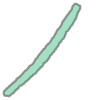

In [98]:
inter_polys['geometry'].values[0]

In [188]:
len(lines)

9

In [209]:
inter_polys['geometry'].values[0].intersects(perpendiculars[0])

True

In [ ]:
poly_list = []
for split_line in perpendiculars:
    split_parts = shapely_split(inter_polys['geometry'].values[0], perpendiculars[num_split])
    poly_list.extend()

In [235]:


perpendiculars.append(inter_polys['geometry'].values[0].boundary) # collection of individual linestrings for splitting in a list and add the polygon lines to it.
merged_lines = shapely.ops.linemerge(perpendiculars)
border_lines = shapely.ops.unary_union(merged_lines)
decomposition = shapely.ops.polygonize(border_lines)

In [268]:
len(splitted_list)

17

In [286]:
splitted_df = gpd.GeoDataFrame(geometry=splitted_list)

In [293]:

cntr = 0
for num, row in splitted_df.iterrows():
    for line, angle in zip(lines, angles):
        pt_1 = line.interpolate(0.1, normalized=True)
        pt_2 = line.interpolate(0.9, normalized=True)
        new_line = LineString([pt_1, pt_2])
        if new_line.intersects(row['geometry']):
            splitted_df.loc[num, "angle"] = angle
            cntr += 1
            
print(cntr)

10


In [294]:
splitted_df

,geometry,angle
0,"POLYGON ((745473.3123960972 7574183.739028698,...",36.433299
1,"POLYGON ((745468.3159157984 7574187.427235804,...",39.577099
2,"POLYGON ((745480.2152959136 7574205.116407522,...",28.754276
3,"POLYGON ((745473.7164390878 7574194.692188271,...",32.640211
4,"POLYGON ((745446.6263089041 7574156.41361214, ...",47.362135
5,"POLYGON ((745443.3047968794 7574160.020941674,...",47.445898
6,"POLYGON ((745448.1642794892 7574158.103350692,...",47.364942
7,"POLYGON ((745456.9918181911 7574165.676683734,...",44.112246
8,"POLYGON ((745491.6647930563 7574222.721367315,...",28.764679


In [295]:
splitted_with_angle_path = "/mnt/storage_4tb/ymi/geo_data/40m_for_ori/citrusuco/row_data/504/splitted_with_angle.geojson"
splitted_df.crs = meta.get('crs')
if os.path.exists(splitted_with_angle_path):
    os.remove(splitted_with_angle_path)
splitted_df.to_file(splitted_with_angle_path, driver='GeoJSON', encoding='utf-8')

In [277]:
line.buffer(-0.1).coords.xy

NotImplementedError: Component rings have coordinate sequences, but the polygon does not

In [266]:
len(splitted_list)

17

In [ ]:
for poly in 

In [236]:
splitted_polys = list(decomposition)

In [237]:
splitted_polys

[<shapely.geometry.polygon.Polygon object at 0x7faee9998588>, <shapely.geometry.polygon.Polygon object at 0x7faee9998940>, <shapely.geometry.polygon.Polygon object at 0x7faee9998da0>, <shapely.geometry.polygon.Polygon object at 0x7faee9998dd8>, <shapely.geometry.polygon.Polygon object at 0x7faee9998e10>, <shapely.geometry.polygon.Polygon object at 0x7faee9998e48>, <shapely.geometry.polygon.Polygon object at 0x7faee9998e80>, <shapely.geometry.polygon.Polygon object at 0x7faee9998eb8>]

In [274]:
splitted_polygons_path = "/mnt/storage_4tb/ymi/geo_data/40m_for_ori/citrusuco/row_data/504/splitted_polygons.geojson"
save_gpd_df(splitted_polygons_path, splitted_list, meta)

/home/user/.virtualenvs/cv34/lib/python3.5/site-packages/geopandas/io/file.py:62: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


In [ ]:
for poly in inter

In [85]:
bounding_polygons

In [87]:
bd_polygons_path = "/mnt/storage_4tb/ymi/geo_data/40m_for_ori/citrusuco/row_data/504/bd_polygons.geojson"
save_gpd_df(bd_polygons_path, bounding_polygons, meta)

In [71]:
for line in lns:
    print(get_azimuth_polyline(line))

28.764678927799743
28.754275888472385
32.64021075391646
36.43329871568823
39.577098824019274
44.11224570597645
47.3649419996797
47.362134819719785
47.44589836579996
